# Lecture 4 - Classifiers Demo
## Logistic regression, soppurt vector machine, decision trees, bagging, boosting
Author: Kaihang Zhang<br>
 khzhang2@connect.hku.hk <br>
208 Haking Wong Building<br>
Department of Civil Engineering<br>
The University of Hong Kong<br>


In [1]:
##################################################################################################################
##      Script template created for the course CIVL 7018 at The University of Hong Kong.                        ##
##      in Spring 2023 semester                                                                                 ##
##      Licensing Information:  You are free to use or extend this project if:                                  ##
##          (1) You don't distribute or publish coding solutions for CIVL 7018 Assignments online.              ##
##          (2) You retain this notice.                                                                         ##
##          (3) You provide clear attribution to The University of Hong Kong                                    ##
##################################################################################################################

## Problem Description

Consider again the probability of a student passing an exam.

A group of 20 students spend between 0 and 6 hours studying for an exam. How does the number of hours spent studying affect the probability that the student will pass the exam? The table shows the number of hours each student spent studying, and whether they passed (1) or failed (0).

Additionally, we consider a second variable, the previous passing rate, which is the number of courses a student has taken and passed divided by total number of courses that student has taken. 

The data is summarized in the table below.

## Data

|Student ID|Study Hours|Prev. Pass Rate|Pass?|
|---       |---        |---            |---  |
|1         |0.5        |0.4            |0|
|2         |0.75       |0.3            |0|
|3         |1          |0.6            |0|
|4         |1.25       |0.4            |0|
|5         |1.5        |0.7            |0|
|6         |1.75       |0.4            |0|
|7         |1.75       |1.0            |1|
|8         |2          |0.3            |0|
|9         |2.25       |0.9            |1|
|10        |2.5        |0.4            |0|
|11        |2.75       |0.7            |1|
|12        |3          |0.3            |0|
|13        |3.25       |0.6            |1|
|14        |3.5        |0.2            |0|
|15        |4          |0.7            |1|
|16        |4.25       |0.5            |1|
|17        |4.5        |0.7            |1|
|18        |4.75       |0.8            |1|
|19        |5          |0.7            |1|
|20        |5.5        |0.8            |1|

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

,ID,Hours,Prev,if_Pass
0,1.0,0.50,0.4,0.0
1,2.0,0.75,0.3,0.0
2,3.0,1.00,0.6,0.0
3,4.0,1.25,0.4,0.0
4,5.0,1.50,0.7,0.0


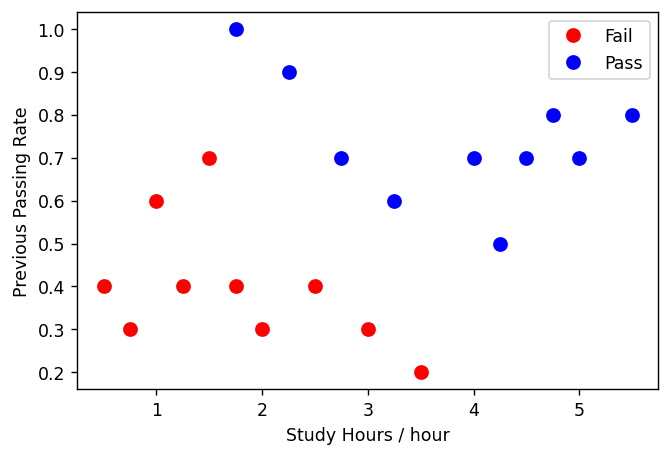

In [3]:
data = np.array([
        [1         ,0.5        ,0.4            ,0],
        [2         ,0.75       ,0.3            ,0],
        [3         ,1          ,0.6            ,0],
        [4         ,1.25       ,0.4            ,0],
        [5         ,1.5        ,0.7            ,0],
        [6         ,1.75       ,0.4            ,0],
        [7         ,1.75       ,1.0            ,1],
        [8         ,2          ,0.3            ,0],
        [9         ,2.25       ,0.9            ,1],
        [10        ,2.5        ,0.4            ,0],
        [11        ,2.75       ,0.7            ,1],
        [12        ,3          ,0.3            ,0],
        [13        ,3.25       ,0.6            ,1],
        [14        ,3.5        ,0.2            ,0],
        [15        ,4          ,0.7            ,1],
        [16        ,4.25       ,0.5            ,1],
        [17        ,4.5        ,0.7            ,1],
        [18        ,4.75       ,0.8            ,1],
        [19        ,5          ,0.7            ,1],
        [20        ,5.5        ,0.8            ,1],
])
data_df = pd.DataFrame(data, columns=['ID', 'Hours', 'Prev', 'if_Pass'])

plt.figure(dpi=125)
plt.plot(data_df.loc[data_df['if_Pass']==0, 'Hours'], data_df.loc[data_df['if_Pass']==0, 'Prev'], 'r.', markersize=15, label='Fail')
plt.plot(data_df.loc[data_df['if_Pass']==1, 'Hours'], data_df.loc[data_df['if_Pass']==1, 'Prev'], 'b.', markersize=15, label='Pass')
plt.xlabel('Study Hours / hour')
plt.ylabel('Previous Passing Rate')
plt.legend()

data_df.head()

## Logistic Regression
### This section, we conly consider the number of studied hours.

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
X = data_df['Hours'].to_numpy().reshape(-1, 1)
y = data_df['if_Pass'].to_numpy()
clf = LogisticRegression(random_state=0, penalty='none').fit(X, y)


In [6]:
print('w0', clf.intercept_)
print('w1', clf.coef_)


w0 [-4.07771764]
w1 [[1.50464522]]


## Support Vector Machine

In [7]:
from sklearn.svm import SVC

In [8]:
X = data_df[['Hours', 'Prev']]
y = data_df['if_Pass']
clf = SVC(C=100, kernel='linear').fit(X, y)  # make C larger, reduce regularization


In [9]:
print('w0', clf.intercept_)
print('w1 w2', clf.coef_)

w0 [-7.87919113]
w1 w2 [[1.60000317 6.39846896]]


x_min 0.25 x_max 5.75
y_min 0.16 y_max 1.04


(0.16, 1.04)

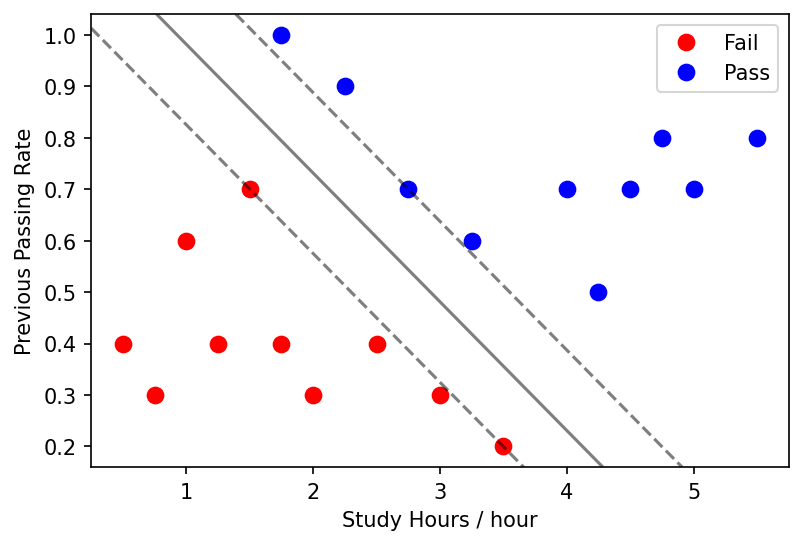

In [11]:
# plot hyperplane
x1 = data_df['Hours'].to_numpy()
x2 = data_df['Prev'].to_numpy()
y = data_df['if_Pass'].to_numpy()

plt.figure(dpi=150)
plt.plot(data_df.loc[data_df['if_Pass']==0, 'Hours'], data_df.loc[data_df['if_Pass']==0, 'Prev'], 'r.', markersize=15, label='Fail')
plt.plot(data_df.loc[data_df['if_Pass']==1, 'Hours'], data_df.loc[data_df['if_Pass']==1, 'Prev'], 'b.', markersize=15, label='Pass')
plt.xlabel('Study Hours / hour')
plt.ylabel('Previous Passing Rate')
plt.legend()

ax = plt.gca()  # obtain current subplot

# obtain the axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()
print('x_min {:.2f}'.format(xlim[0]), 'x_max {:.2f}'.format(xlim[1]))
print('y_min {:.2f}'.format(ylim[0]), 'y_max {:.2f}'.format(ylim[1]))

# plot the hyperplane
axisx = np.linspace(xlim[0], xlim[1], 50)
axisy = np.linspace(ylim[0], ylim[1], 50)
axisx, axisy = np.meshgrid(axisx, axisy)
xy = np.vstack([axisx.ravel(), axisy.ravel()]).T

Z = clf.decision_function(xy).reshape(axisx.shape)

ax.contour(axisx, axisy, Z
           ,colors="k"
           ,levels=[-1, 0, 1] #画三条等高线，分别是Z为-1，Z为0和Z为1的三条线
           ,alpha=0.5#透明度
           ,linestyles=["--","-","--"])

ax.set_xlim(xlim)#设置x轴取值
ax.set_ylim(ylim)


## Decision Trees